In [20]:
from dotenv import load_dotenv
import os
load_dotenv()
from openai import OpenAI
import requests
import json
import re
import numpy as np

import sys
sys.path.append("../source")
import helpers
import data
import api

#import importlib
#importlib.reload(helpers)

client = OpenAI()

Try to create a corpus search call with smart key words generated by GPT3.5

In [5]:
messages = [{ "role": "system", "content": "You assist a corpus search by calling a corpus search function with simple strings or regular expressions in Python format that can be directly used."},
            { "role": "user", "content": "I want to find sentences in a corpus that serve as examples for the following grammar rule: Can form negative 'wh-' interrogative clauses." }]

tools = [
    {
        "type": "function",
        "function": {
            "name": "search_corpus",
            "description": "Search a sentence corpus for a keyword",
            "parameters": {
                "type": "object",
                "properties": {
                    "keyword": {
                        "type": "string",
                        "description": "One single keyword to search",
                    },
                },
                "required": ["keyword"],
            },
        }
    },
]
response = client.chat.completions.create(
    model=os.getenv("OPENAI_DEFAULT_MODEL"),
    messages=messages,
    temperature=1,
    max_tokens=128,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    n=1,
    tools=tools, # tool_choice={"type": "function", "function": {"name": "get_n_day_weather_forecast"}}
)
json.loads(response.choices[0].message.tool_calls[0].function.arguments)

{'keyword': "Can form negative 'wh-' interrogative clauses"}

Tool use does not look that promising.

Ask GPT4 for regular expressions of the corpus search.

In [6]:
egp = helpers.get_egp()

In [91]:
rule

#                                                                 760
SuperCategory                                                    PAST
SubCategory                                   past perfect continuous
Level                                                              B2
Lexical Range                                                     1.0
guideword                                              FORM: NEGATIVE
Can-do statement                          Can use the negative form. 
Example             Laura realised that she had not been studying ...
Type                                                             FORM
Name: 759, dtype: object

In [95]:
# sample rule
rule = egp.sample(1).iloc[0]
# compose prompt
prompt = f"""I want to find sentences with {" ".join(rule['Can-do statement'].split(" ")[2:]).replace(".","")} (category: {rule['SuperCategory']}: {rule['SubCategory']}) a text.
What are Python regular expressions I should search for?
Return a json array with basic regex: {{ "search": [regex1, regex2, ...] }}."""
print(prompt)
# query API
messages = [{ "role": "user", "content": prompt}]
response = client.chat.completions.create(
    model="gpt-4-turbo-preview",#"gpt-3.5-turbo-1106",#os.getenv("OPENAI_DEFAULT_MODEL"),
    messages=messages,
    response_format={ "type": "json_object" },
    n=1,
    max_tokens=512,
)
#print(response.choices[0].message.content)

matched_strings = set()
all_expressions = set()
strings_to_search = rule['Example'].split("\n\n")

for choice in response.choices:
    all_expressions.update(json.loads(choice.message.content)['search'])
for pattern in all_expressions:
    print(pattern)

for string in strings_to_search:
    for pattern in all_expressions:
        if re.search(pattern.replace("\x08", "").replace("\x09", "").replace("++", "+"), string, re.IGNORECASE):
            matched_strings.add(string)
            break

print(rule['Example'])

print(len(matched_strings)/len(strings_to_search))

other_rule = egp.sample(1).iloc[0]
string_prob_not_to_match = other_rule['Example'].split("\n\n")
for string in string_prob_not_to_match:
    for pattern in all_expressions:
        if re.search(pattern.replace("\x08", "").replace("\x09", "").replace("++", "+"), string, re.IGNORECASE):
            print(string)
            break


I want to find sentences with the singular reflexive pronouns 'myself', 'yourself', 'himself' and 'herself' for emphasis (category: PRONOUNS: reflexive) a text.
What are Python regular expressions I should search for?
Return a json array with basic regex: { "search": [regex1, regex2, ...] }.
\bhimself\b
\byourself\b
\bmyself\b
\bherself\b
The best solution will be if you decide yourself what to do. 

I think it was the director himself who guided the actress through our wonderful school gardens to film the opening scene there. 

The food was delicious, especially the cake, which Sandra had cooked herself.
1.0
I myself, having been educated the hard way, would specifically insist on them getting the best possible school education. 


In [96]:
print(response.choices[0].message.content)


{
  "search": [
    "\\bmyself\\b",
    "\\byourself\\b",
    "\\bhimself\\b",
    "\\bherself\\b"
  ]
}


Find the rules in corpus

In [12]:
ds = data.DialogSum()
sents = ds.get_all_sentences()

dd = data.DailyDialog()
sents += dd.get_all_sentences()

wow = data.WoW()
sents += wow.get_all_sentences()

sents += data.get_cefr_sentences()

In [65]:
sents = set(sents)

In [98]:
hits = []
for string in sents:
    for pattern in all_expressions:
        if re.search(pattern.replace("\x08", "").replace("\x09", "").replace("++", "+"), string):
            hits.append(string)
            break
    if len(hits)>50:
        break

print(len(hits))
hits[:25]

51


["I'm just not a fan of the Republican party myself.",
 'Never starve yourself.',
 'I think I limit myself to certain meats only and that is it.',
 "Don't worry him, he has been grown up and I think he can take himself very well.",
 'Will you be buying it by yourself?',
 "Third, don't tire yourself out, but don't be lazy.",
 "Well, uh, I'll let you decide that for yourself.",
 'I think you can go yourself and show concern to her since she sometimes would take your advice.',
 'In return, prosecutors say, he sought positive coverage of himself and wife Sara on a news website controlled by the company’s former chairman, Shaul Elovitch.',
 'There are so many varieties of cheese in the world that limiting yourself to just cheddar cheese would get boring.',
 'In order to qualify, you must be able to pay about 30 percent of the rent yourself.',
 'Raikkonen has posted Lotusonly victory this year, with himself and the team both fourth in the respective driver and constructor standings.',
 'Not 

In [85]:
hits[8]

'I hardly dare call the police.'

In [99]:
prompt = helpers.get_prompt(rule, n_examples=0, mark_words=False)
prompt += "\nCreate a short step-by-step instruction to check whether a sentence is an instance of this rule."
messages = [{ "role": "user", "content": prompt }]
instruction = api.get_openai_chat_completion(messages, max_tokens=128)[0]
print(instruction)

1. Identify the reflexive pronouns 'myself', 'yourself', 'himself', or 'herself' in the sentence.
2. Determine if the reflexive pronoun is used in a singular context, referring back to the subject of the sentence.
3. Check if the reflexive pronoun is used for emphasis, highlighting the subject's personal involvement in the action.
4. If the sentence follows all the criteria above, it is an instance of the grammar rule "Can use the singular reflexive pronouns 'myself', 'yourself', 'himself', and 'herself' for emphasis."


In [113]:
prompt = f"""
Do the following to classify whether following sentence is an instance of the rule.
{instruction}
Sentence: {hits[13]}
"""
#for i, hit in enumerate(hits[10:20]):
#    prompt += f"{i+1}. {hit}\n"
prompt += "Output format:\n[Explanation]\n###YES|NO"
print(prompt)
messages = [{ "role": "user", "content": prompt }]
response = api.get_openai_chat_completion(messages, model="gpt-4-turbo-preview",max_tokens=512)[0]
print(response)


Do the following to classify whether following sentence is an instance of the rule.
1. Identify the reflexive pronouns 'myself', 'yourself', 'himself', or 'herself' in the sentence.
2. Determine if the reflexive pronoun is used in a singular context, referring back to the subject of the sentence.
3. Check if the reflexive pronoun is used for emphasis, highlighting the subject's personal involvement in the action.
4. If the sentence follows all the criteria above, it is an instance of the grammar rule "Can use the singular reflexive pronouns 'myself', 'yourself', 'himself', and 'herself' for emphasis."
Sentence: No, mom, I can manage it by myself.
Output format:
[Explanation]
###YES|NO
###YES
1. The reflexive pronoun in the sentence is 'myself'.
2. 'Myself' is used in a singular context, referring back to the subject of the sentence, which is 'I'.
3. The reflexive pronoun 'myself' is used for emphasis, highlighting the subject's personal involvement in the action of managing it.
4. The

In [58]:
true_positives_idx = np.array([answer == 'Yes' for num, answer in re.findall(r'(\d+)\.\s(Yes|No)', response)])

In [60]:
np.array(hits[:10])[true_positives_idx]

array(['Times have certainly changed, quite a lot in writing styles, such as hers, as well!',
       'I asked her quite a few questions.',
       'I think Manhattan has quite a few ethnic restaurants last time I was there.',
       "Damn that's quite a while!",
       "No she's just one of those people that get out there, run, and the endorphins kick in - I would imagine it's quite a bit of mental strength as well.",
       'It can be quite a long job.'], dtype='<U148')

In [229]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [236]:
can_do_mapping, level_mapping = helpers.map_egp_id('../data/egp_list.xlsx')

def find_rule(example):
    annos = api.get_annotations(example)
    for id, begin, end in annos:
        if can_do_mapping[id] == rule['Can-do statement']:
            #print(f'Found in {example} at {example[begin:end]}')
            return True
    return False

ratios = []
for idx, rule in tqdm(egp.iterrows(), total=len(egp)):
    if rule['Type'] == "FORM":
        if isinstance(rule['Example'], str):
            strings_to_search = rule['Example'].split("\n\n")
            found = [find_rule(example) for example in strings_to_search]
            ratios.append(sum(found) / len(found))
            # print(sum(found) / len(found))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1222/1222 [03:44<00:00,  5.44it/s]


In [235]:
for idx, rule in tqdm(egp.iterrows(), total=len(egp)):
    if rule['Type'] == "FORM":
        if not isinstance(rule['Example'], str):
            print(rule)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1222/1222 [00:00<00:00, 23780.85it/s]

#                                      212
SuperCategory                      CLAUSES
SubCategory                 interrogatives
Level                                   B1
Lexical Range                          NaN
guideword           FORM: 'WHICH', 'WHOSE'
Can-do statement                       NaN
Example                                NaN
Type                                  FORM
Name: 211, dtype: object
#                                         372
SuperCategory                          FUTURE
SubCategory         future perfect continuous
Level                                      B2
Lexical Range                             NaN
guideword                      FORM: NEGATIVE
Can-do statement                          NaN
Example                                   NaN
Type                                     FORM
Name: 371, dtype: object


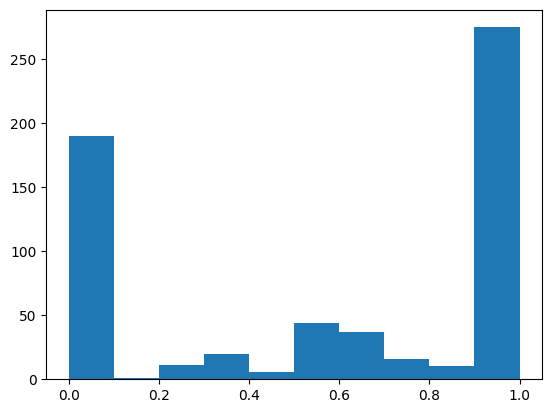

In [237]:
plt.hist(ratios)
plt.show()

In [239]:

np.mean(ratios)

0.5803734061930783